<a href="https://colab.research.google.com/github/AvellinaLeong/NHM-Nannofossil-Segmentation-Project/blob/main/04_confidence_intervals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Calculate Confidence Intervals for Binary Classification results

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Set script location to own development space
MY_DEVELOPMENT_SPACE = '/content/drive/MyDrive/development/avellina/'
import os
os.chdir(MY_DEVELOPMENT_SPACE)
!pwd
!ls

Mounted at /content/drive/
/content/drive/MyDrive/development/avellina
Binary_Classification_notebooks  Detectron2_notebooks  Morphometrics_notebooks	src
detectron2			 Mask-RCNN	       output


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Load the dataframe with binary classification predictions (from previous notebook script)
df = pd.read_csv('/content/drive/MyDrive/data/species_53/Binary_Classification/model_save/epoch_100_dataframe_last.csv')

In [ ]:
# Extract true labels and continuous predictions
true_classes = df['groundtruth_labels'].values
continuous_predictions = df['Predictions'].values

In [ ]:
# Apply a threshold to convert continuous predictions to binary class labels
threshold = 0.5  # You can adjust this threshold as needed
predicted_classes = np.where(continuous_predictions >= threshold, 1, 0)

In [ ]:
# Function to calculate sensitivity and specificity
def cal_sensitivity_specificity(cm, print_value=0):
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    precision = TP / (TP + FP)
    prevalence = (TP + FN) / (TP + TN + FP + FN)
    PPV = (sensitivity * prevalence) / ((sensitivity * prevalence) + ((1.0 - specificity) * (1.0 - prevalence)))
    NPV = (specificity * (1 - prevalence)) / ((specificity * (1 - prevalence)) + ((1 - sensitivity) * prevalence))

    if print_value != 0:
        print("Sensitivity = ", sensitivity)
        print("Specificity = ", specificity)
        print("Precision   = ", precision)
        print("Prevalence  = ", prevalence)
        print("PPV         = ", PPV)
        print("NPV         = ", NPV)

    return sensitivity, specificity, precision, PPV, NPV

In [ ]:
# Function to calculate 95% confidence intervals for AUC using bootstrapping
def acu_95CI_bootstrap(true_classes, test_predictions, nsample=5000):
    auc_values = []
    for i in range(nsample):
        idx = np.random.randint(test_predictions.shape[0], size=test_predictions.shape[0])
        roc_auc = roc_auc_score(true_classes[idx], test_predictions[idx])
        auc_values.append(roc_auc)

    CI95 = np.percentile(auc_values, (2.5, 97.5))  # The 95% CI
    print("95% CI for AUC = ", CI95)

    # Plot the distribution of AUC values
    plt.figure(figsize=(10, 6))
    sns.displot(data=auc_values, bins=20, kde=True, height=3.5, aspect=1.618)
    plt.xlabel("ROC_AUC Score", fontsize=13)
    plt.ylabel("", fontsize=13)
    plt.show()

    return CI95, auc_values

In [ ]:
# Function to calculate 95% confidence intervals for Sensitivity and Specificity using bootstrapping
def SensitivitySpecificity_95CI_bootstrap(true_classes, predicted_classes, nsample=5000):
    sen_values = []
    spe_values = []

    for i in range(nsample):
        idx = np.random.randint(predicted_classes.shape[0], size=predicted_classes.shape[0])
        cm = confusion_matrix(true_classes[idx], predicted_classes[idx])
        sens, spec, _, _, _ = cal_sensitivity_specificity(cm, print_value=0)
        sen_values.append(sens)
        spe_values.append(spec)

    CI95_sen = np.percentile(sen_values, (2.5, 97.5))  # The 95% CI for sensitivity
    CI95_spe = np.percentile(spe_values, (2.5, 97.5))  # The 95% CI for specificity

    print("Sensitivity 95% CI = ", CI95_sen)
    print("Specificity 95% CI = ", CI95_spe)

    return CI95_sen, CI95_spe

In [ ]:
# Calculate confusion matrix and initial sensitivity/specificity
cm = confusion_matrix(true_classes, predicted_classes)
sensitivity, specificity, precision, PPV, NPV = cal_sensitivity_specificity(cm, print_value=1)

Sensitivity =  0.9454545454545454
Specificity =  0.7931034482758621
Precision   =  0.7761194029850746
Prevalence  =  0.43137254901960786
PPV         =  0.7761194029850745
NPV         =  0.9504132231404958


Calculating confidence intervals...
95% CI for AUC =  [0.89214597 0.95632852]


<Figure size 1000x600 with 0 Axes>

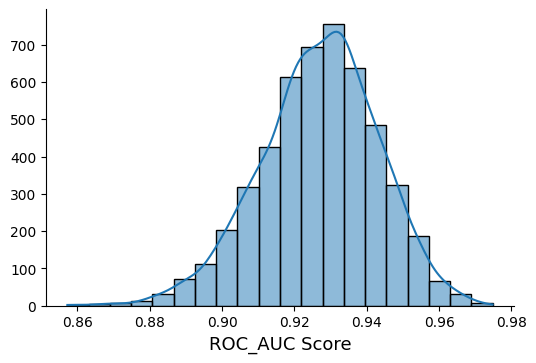

Sensitivity 95% CI =  [0.89719626 0.98245614]
Specificity 95% CI =  [0.72482735 0.85815603]


In [ ]:
# Print results
print("Calculating confidence intervals...")
auc_ci, auc_values = acu_95CI_bootstrap(true_classes, continuous_predictions)
sensitivity_ci, specificity_ci = SensitivitySpecificity_95CI_bootstrap(true_classes, predicted_classes)

In [ ]:
# Display sensitivity and specificity with confidence intervals
print(f"Sensitivity: {sensitivity:.2f} (95% CI: {sensitivity_ci[0]:.2f} - {sensitivity_ci[1]:.2f})")
print(f"Specificity: {specificity:.2f} (95% CI: {specificity_ci[0]:.2f} - {specificity_ci[1]:.2f})")

Sensitivity: 0.95 (95% CI: 0.90 - 0.98)
Specificity: 0.79 (95% CI: 0.72 - 0.86)
